<a href="https://colab.research.google.com/github/juacastanori/TAM/blob/main/Parcial_2/Dashboard_TAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Dashboard Parcial 2 / TAM

## Hecho por: Juan Jerónimo Castaño Rivera. Oscar Andres Gutierrez. Wilmer Sebastián Pérez

Instalar Streamlit, dataset USPS, etc

In [ ]:
# ─── librerías de Python ───────────────────────────────────────────
!pip install streamlit umap-learn h5py scikit-learn --quiet

# ─── descargar el .h5 si aún no está en la carpeta de trabajo ─────
import pathlib, subprocess, textwrap, json, math, random, os, sys, html, time
if not pathlib.Path("usps.h5").exists():
    !pip install gdown --quiet
    !gdown --id 1RlJkocG7354lh4jMn0onmG9a0u8CRvez -O usps.h5

# ─── cloudflared (por si corres en Colab) ──────────────────────────
!curl -L https://github.com/cloudflare/cloudflared/releases/latest/download/cloudflared-linux-amd64 -o cloudflared
!chmod +x cloudflared

# ─── carpeta para páginas ──────────────────────────────────────────
!mkdir -p pages


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 56.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 4.5 MB/s eta 0:00:00
/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1RlJkocG7354lh4jMn0onmG9a0u8CRvez
To: /content/usps.h5
100% 2.91M/2.91M [00:00<00:00, 176MB/s]
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 

Carga de datos

In [ ]:
%%writefile utils_usps.py
import numpy as np, h5py, streamlit as st
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import umap

# ---------- 1. Cargar USPS ----------------------------------------------------
@st.cache_data(show_spinner="📥 Cargando dataset USPS...")
def load_usps(h5_path="usps.h5"):
    with h5py.File(h5_path, "r") as f:
        X_train = np.array(f["train"]["data"])
        y_train = np.array(f["train"]["target"])
        X_test  = np.array(f["test"]["data"])
        y_test  = np.array(f["test"]["target"])
    X = np.concatenate([X_train, X_test])
    y = np.concatenate([y_train, y_test])
    return X.astype(np.float32), y.astype(int)

# ---------- 2. Pre‑escalado ---------------------------------------------------
@st.cache_data
def scale_data(X):
    scaler = StandardScaler()
    return scaler.fit_transform(X)

# ---------- 3. PCA ------------------------------------------------------------
@st.cache_data
def compute_pca(X_scaled, n_components=2):
    pca = PCA(n_components=n_components, random_state=42)
    return pca.fit_transform(X_scaled), pca.explained_variance_ratio_

# ---------- 4. UMAP -----------------------------------------------------------
@st.cache_data
def compute_umap(X_scaled, n_neighbors=15, min_dist=0.1):
    reducer = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        metric="euclidean",
        random_state=42,
    )
    return reducer.fit_transform(X_scaled)

# ---------- 5. Dibujar muestras ----------------------------------------------
def plot_samples_grid(X, y, rows, cols, mode, start=0):
    fig, axes = plt.subplots(rows, cols, figsize=(1.5 * cols, 1.5 * rows))
    n_samples = rows * cols
    if mode == "Aleatorio":
        idx = np.random.choice(len(X), n_samples, replace=False)
    else:
        if start + n_samples > len(X):
            start = max(0, len(X) - n_samples)
        idx = np.arange(start, start + n_samples)
    for ax, i in zip(axes.flat, idx):
        ax.imshow(X[i].reshape(16, 16), cmap="gray")
        ax.set_title(int(y[i]), fontsize=9)
        ax.axis("off")
    plt.tight_layout()
    return fig

# ---------- 6. Scatter con imágenes ------------------------------------------
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def scatter_with_images(emb, X_img, labels, n_overlay, title):
    fig, ax = plt.subplots(figsize=(10, 8))
    sc = ax.scatter(emb[:, 0], emb[:, 1], c=labels, cmap="tab10", s=10, alpha=0.25)
    ax.set_title(title)
    ax.set_xticks([]); ax.set_yticks([])
    # superponer imágenes
    idx = np.random.choice(len(emb), n_overlay, replace=False)
    for i in idx:
        img = X_img[i].reshape(16, 16)
        img_box = OffsetImage(img, cmap="gray", zoom=0.8)
        ab = AnnotationBbox(img_box, (emb[i, 0], emb[i, 1]), frameon=False)
        ax.add_artist(ab)
    cbar = plt.colorbar(sc, ax=ax, ticks=np.arange(10))
    cbar.set_label("Etiqueta")
    plt.tight_layout()
    return fig


Writing utils_usps.py


Página 1: Mostrar muestras del Dataset

In [ ]:
%%writefile 0_👋_Home.py
import streamlit as st
from utils_usps import load_usps, plot_samples_grid

st.set_page_config(page_title="USPS Dashboard", page_icon="📬")

# ─── Título e introducción ───────────────────────────────────────────────────
st.title("📬 Dashboard USPS – Visión general")
st.markdown(
"""
Este dashboard interactivo permite explorar el dataset **USPS**, una colección de imágenes en escala de grises de dígitos manuscritos (16×16 píxeles), ampliamente utilizada en tareas de clasificación.

🔍 A lo largo de las secciones, se abordan dos aspectos fundamentales del aprendizaje automático:

- **Reducción de Dimensión:** Se comparan las técnicas **PCA** (análisis de componentes principales) y **UMAP**, tanto desde su teoría como desde visualizaciones de las proyecciones 2D generadas.
- **Clasificadores Supervisados:** Se entrenan y visualizan los resultados de tres modelos aplicados sobre las representaciones reducidas:
  - Regresión Logística Multiclase
  - Red Neuronal Densa (DNN)
  - k-Nearest Neighbors (KNN)

Este entorno proporciona una visión didáctica, visual e interactiva del flujo típico de un proyecto de aprendizaje supervisado: desde la representación de los datos hasta su clasificación.

📺 **Video explicativo:** [Ver en YouTube](https://youtu.be/v-8RH-T1R8c)

---

### Secciones

| Sección | Contenido |
|---------|-----------|
| **Inicio** | Descripción y galería interactiva del dataset. |
| **Reducción de Dimensión** | Comparación teórica y visual de **PCA** y **UMAP**. |
| **Clasificadores** | Visualización y evaluación de **DNN**, **KNN** y **Logistic Regression** sobre datos reducidos. |

---
"""
)

# ─── Galería interactiva (se mantiene) ───────────────────────────────────────
st.subheader("👁️ Muestras del dataset")
X, y = load_usps()

cols = st.columns(2)
with cols[0]:
    rows = st.slider("Filas", 1, 10, 3)
    cols_g = st.slider("Columnas", 1, 20, 10)
with cols[1]:
    mode = st.radio("Modo", ("Aleatorio", "Secuencial"), horizontal=True)
    start = st.number_input("Índice inicial", 0, len(X) - 1, 0, 1) if mode == "Secuencial" else 0

if st.button("🔄 Mostrar muestras"):
    fig = plot_samples_grid(X, y, rows, cols_g, mode, int(start))
    st.pyplot(fig)
else:
    st.info("Ajusta parámetros y pulsa **Mostrar muestras**.")



Writing 0_👋_Home.py


Página 2: Reducción de dimensión (PCA y UMAP)

In [ ]:
%%writefile pages/1_📏_Reduccion_Dimensiones.py
import streamlit as st
from utils_usps import (
    load_usps,
    scale_data,
    compute_pca,
    compute_umap,
    scatter_with_images,
)

st.header("📏 Reducción de Dimensión – PCA & UMAP")

tab_pca, tab_umap = st.tabs(["📉 PCA", "🌀 UMAP"])

# =====================================================
# ➤  1) TAB PCA
# =====================================================
with tab_pca:
    st.subheader("📉 PCA 2 D – Teoría")

    RAW = (
        "https://raw.githubusercontent.com/AndresOscar/"
        "-Machine-Learning-Theory-Course/main/Parcial_2_TAM/Dashboard/"
    )

    # Mostrar las dos imágenes comparativas en horizontal
    col1, col2 = st.columns(2)
    with col1:
        st.image(RAW + "Captura%20de%20pantalla%202025-07-17%20203009.png",
                 caption="PCA - Visualización con imágenes",
                 use_container_width=True)
    with col2:
        st.image(RAW + "Captura%20de%20pantalla%202025-07-17%20203029.png",
                 caption="PCA - Coloreado por etiquetas",
                 use_container_width=True)

    st.markdown("#### 📌 **Objetivo:**")
    st.markdown("Encontrar una transformación lineal que proyecte los datos en un espacio de menor dimensión, **maximizando la varianza** de los datos proyectados.")

    st.markdown("#### 📌 **Modelo:**")
    st.latex(r"Z = XW")
    st.markdown("""
    Donde:
    - $ X \in \mathbb{R}^{n x d} $: datos centrados (media cero)
    - $ W \in \mathbb{R}^{d x k} $: vectores propios asociados a los k mayores autovalores de la matriz de covarianza de $ X $
    - $ Z $: proyección de los datos en menor dimensión
    """)

    st.markdown("#### 📌 **Problema de optimización:**")
    st.latex(r"\max_{W \in \mathbb{R}^{d \times k}} \operatorname{tr}(W^T S W) \quad \text{sujeto a} \quad W^T W = I")
    st.markdown("""
    Donde:
    - $ S = \frac{1}{n} X^T X $ : matriz de covarianza muestral
    - La traza $ \operatorname{tr}(W^T S W) $ representa la varianza total proyectada
    - La restricción $ W^T W = I $ garantiza vectores ortonormales
    """)

    st.markdown("#### 📌 **Solución:**")
    st.markdown("Seleccionar los **k autovectores principales** de \( S \) (mayores autovalores). Estos definen las direcciones de máxima varianza.")

    st.markdown("#### 📌 **Propiedades:**")
    st.markdown("""
    - PCA es **no supervisado**
    - Proyección lineal
    - Retiene estructura **global lineal**
    """)

    st.divider()

    # ────────── Interactividad PCA ─────────────
    with st.sidebar:
        st.markdown("### Parámetros PCA")
        sample_p = st.slider("Sub‑muestra", 1000, 9298, 5000, 500, key="sample_pca")
        n_overlay_p = st.slider("Imágenes superpuestas", 10, 100, 40, 5, key="overlay_pca")
        btn_pca = st.button("🚀 Calcular PCA", key="btn_pca")

    X, y = load_usps()

    if btn_pca:
        import numpy as np
        idx = st.session_state.get("pca_idx")
        if idx is None or len(idx) != sample_p:
            idx = np.random.choice(len(X), sample_p, replace=False)
            st.session_state["pca_idx"] = idx
        X_sub, y_sub = X[idx], y[idx]

        X_scaled = scale_data(X_sub)
        emb, var_ratio = compute_pca(X_scaled, 2)
        st.write(f"Varianza explicada total: **{var_ratio.sum():.3f}**")

        fig = scatter_with_images(emb, X_sub, y_sub, n_overlay_p, "PCA 2D")
        st.pyplot(fig)
    else:
        st.info("Configura parámetros y pulsa **Calcular PCA**.")

# =====================================================
# ➤  2) TAB UMAP
# =====================================================
with tab_umap:
    st.subheader("🌀 UMAP 2 D – Teoría")

    st.markdown("#### 📌 **Objetivo:**")
    st.markdown("Encontrar una proyección de baja dimensión que preserve la **estructura topológica local** del espacio original (vecindarios).")

    st.markdown("#### 📌 **Modelo:**")
    st.markdown("""
    UMAP se basa en:
    - Modelar los datos sobre una **variedad Riemanniana**
    - Construir un **grafo difuso** de conectividad local en alta dimensión
    - Preservar ese grafo en baja dimensión mediante minimización de divergencia
    """)

    st.markdown("#### 📌 **Problema de optimización:**")

    st.markdown("**1. Construcción del grafo en alta dimensión:**")

    st.latex(r"p_{j|i} = \exp\left(-\frac{\lVert x_i - x_j \rVert^2}{\sigma_i^2}\right)")

    st.markdown("Con $ \sigma_i $ ajustado según la entropía local (dependiente de `n_neighbors`). Se simetriza como:")

    st.latex(r"w_{ij} = p_{j|i} + p_{i|j} - p_{j|i} \cdot p_{i|j}")

    st.markdown("**2. Proyección a baja dimensión:**")

    st.latex(r"q_{ij} = \frac{1}{1 + a\lVert y_i - y_j \rVert^{2b}}")

    st.markdown("**3. Función de costo (Cross-Entropy entre grafos):**")

    st.latex(r"\mathcal{C} = \sum_{(i,j)} \left[w_{ij} \log q_{ij} + (1 - w_{ij}) \log(1 - q_{ij})\right]")

    st.markdown("Los hiperparámetros `a`, `b` ajustan la forma de la curva tipo sigmoide que modela la probabilidad en el espacio embebido.")

    # Añadir imagen representativa UMAP
    st.image(
        "https://raw.githubusercontent.com/AndresOscar/-Machine-Learning-Theory-Course/main/Parcial_2_TAM/Dashboard/1_fGQImmija7kepddB7SFaGA.jpg",
        caption="Representación visual del grafo en UMAP",
        use_container_width=True
    )

    st.divider()

    sub_interactivo, sub_imgs = st.tabs(["⚙️ Interactivo", "🖼️ Ejemplos precalculados"])

    # ────────── Interactivo UMAP ─────────────
    with sub_interactivo:
        with st.sidebar:
            st.markdown("### Parámetros UMAP")
            sample_u = st.slider("Sub‑muestra", 1000, 9298, 5000, 500, key="sample_umap")
            n_neighbors = st.slider("n_neighbors", 5, 100, 15, 5, key="nn_umap")
            min_dist   = st.slider("min_dist", 0.0, 0.99, 0.1, 0.01, key="md_umap")
            n_overlay_u = st.slider("Imágenes superpuestas", 10, 100, 40, 5, key="overlay_umap")
            btn_umap = st.button("🚀 Calcular UMAP", key="btn_umap")

        X, y = load_usps()

        if btn_umap:
            import numpy as np
            idx = st.session_state.get("umap_idx")
            if idx is None or len(idx) != sample_u:
                idx = np.random.choice(len(X), sample_u, replace=False)
                st.session_state["umap_idx"] = idx
            X_sub, y_sub = X[idx], y[idx]

            st.write(f"Sub‑muestra {sample_u} · n_neighbors={n_neighbors} · min_dist={min_dist}")

            X_scaled = scale_data(X_sub)
            emb = compute_umap(X_scaled, n_neighbors, min_dist)

            fig = scatter_with_images(
                emb, X_sub, y_sub, n_overlay_u,
                f"UMAP 2D (n={n_neighbors}, dist={min_dist})"
            )
            st.pyplot(fig)
        else:
            st.info("Define parámetros y pulsa **Calcular UMAP**.")

    # ────────── Precalculadas ─────────────
    with sub_imgs:
        PRECALC = {
            5:  RAW + "Captura%20de%20pantalla%202025-07-15%20205000.png",
            15: RAW + "Captura%20de%20pantalla%202025-07-15%20205015.png",
            30: RAW + "Captura%20de%20pantalla%202025-07-15%20205648.png",
            50: RAW + "Captura%20de%20pantalla%202025-07-15%20205706.png",
        }

        sel = st.select_slider(
            "n_neighbors",
            options=[5, 15, 30, 50],
            value=15,
            format_func=lambda x: f"{x} vecinos",
        )
        st.image(PRECALC[sel], caption=f"UMAP precalculado (n_neighbors = {sel})",
                 use_container_width=True)
        st.markdown(
            """
*Las capturas aceleran la exploración sin esperar al cálculo interactivo.*
Usa la pestaña **Interactivo** para otros valores.
"""
        )


Writing pages/1_📏_Reduccion_Dimensiones.py


Página 3: Clasificadores

- k-NN

- LogisticRegressor

- Red DNN

In [ ]:
%%writefile pages/2_🧠_Clasificadores.py
import streamlit as st

st.set_page_config(page_title="Clasificadores", page_icon="🧠")
st.header("🧠 Clasificadores aplicados al dataset USPS")

st.markdown(
"""
En esta sección se comparan dos clasificadores entrenados sobre el espacio reducido por **PCA**:

1. **Regresión Logística Multiclase (One-vs-Rest)**
2. **Red Neuronal Densa (DNN)**

Cada modelo se evalúa con cuatro visualizaciones clave:

- Proyección PCA con imágenes superpuestas
- Matriz de confusión
- Curvas ROC por clase
- Predicciones graficadas sobre el plano PCA
"""
)

# ─────── Rutas a las imágenes desde GitHub ──────────────────────────────────

RAW_BASE = (
    "https://raw.githubusercontent.com/AndresOscar/"
    "-Machine-Learning-Theory-Course/main/Parcial_2_TAM/Dashboard/"
)

IMGS = {
    "LogisticRegression": [
        "Captura de pantalla 2025-07-15 214036.png",
        "Captura de pantalla 2025-07-15 214049.png",
        "Captura de pantalla 2025-07-15 214104.png",
        "Captura de pantalla 2025-07-15 214135.png",
    ],
    "DNN": [
        "Captura de pantalla 2025-07-15 214307.png",
        "Captura de pantalla 2025-07-15 214317.png",
        "Captura de pantalla 2025-07-15 214333.png",
        "Captura de pantalla 2025-07-15 214341.png",
    ],
    "KNN": [
        "Captura de pantalla 2025-07-16 010352.png",
        "Captura de pantalla 2025-07-16 010407.png",
        "Captura de pantalla 2025-07-16 010417.png",
        "Captura de pantalla 2025-07-16 010437.png",
    ],
}
# ─────── Tabs principales por modelo ────────────────────────────────────────
tab_lr, tab_dnn, tab_knn = st.tabs(
    ["📈 LogisticRegression (PCA)", "🔬 DNN (PCA)", "📍 k‑NN (UMAP)"]
)


# ─────── Tab Logistic Regression ────────────────────────────────────────────
with tab_lr:
    st.subheader("📈 Regresión Logística Multiclase")

    st.markdown(r"""
**Objetivo:** Modelar la probabilidad de que una observación pertenezca a una clase, usando una función logística sobre una combinación lineal de variables de entrada.

### 📌 Modelo

Para un problema de clasificación con datos $\mathbf{x}_i \in \mathbb{R}^d$ y etiquetas $y_i \in \{0, 1\}$:

$$
P(y = 1 \mid \mathbf{x}) = \sigma(\mathbf{w}^\top \mathbf{x} + b) = \frac{1}{1 + \exp(-\mathbf{w}^\top \mathbf{x} - b)}
$$

donde:
- $\mathbf{w} \in \mathbb{R}^d$ es el vector de pesos
- $b \in \mathbb{R}$ es el sesgo
- $\sigma(z)$ es la función sigmoide

### 📌 Problema de optimización

Minimiza la pérdida logarítmica regularizada:

$$
\min_{\mathbf{w}, b} \ \frac{1}{n} \sum_{i=1}^n [-y_i \log(\hat{y}_i) - (1 - y_i)\log(1 - \hat{y}_i)] + \lambda R(\mathbf{w})
$$

donde:
- $\hat{y}_i = \sigma(\mathbf{w}^\top \mathbf{x}_i + b)$
- $R(\mathbf{w})$ es la regularización (usualmente L2):
$$
R(\mathbf{w}) = \frac{1}{2} \|\mathbf{w}\|_2^2
$$

### 📌 Predicción

La clase se predice según:

$$
\hat{y} =
\begin{cases}
1 & \text{si } \sigma(\mathbf{w}^\top \mathbf{x} + b) \geq 0.5 \\
0 & \text{si } \sigma(\mathbf{w}^\top \mathbf{x} + b) < 0.5
\end{cases}
$$


### 1. Elección de Hiperparámetros

#### 📌 PCA
- `n_components = 40`: se seleccionó este valor al observar que **se conserva más del 90 % de la varianza** del conjunto USPS.
- Esta proyección mantiene la estructura principal de los datos con menor complejidad computacional.

#### 📌 Regresión Logística
- Se usó `LogisticRegression` con parámetros por defecto (`solver='lbfgs'`).
- No se ajustó el hiperparámetro `C`, ya que el objetivo era tener un modelo de referencia (baseline) sin sobreajuste fino.
- No se aplicó regularización explícita.

---

### 2. Estrategia de Entrenamiento

- Se separaron correctamente `X_train` y `X_test` desde el inicio.
- Se aplicó escalado con `StandardScaler` antes de aplicar PCA.
- PCA se ajustó **solo con datos de entrenamiento**, para evitar _data leakage_.
- Se entrenó `LogisticRegression` sobre `X_train_pca` y se evaluó en `X_test_pca`.

---
    """)

    for i, desc in enumerate([
        "1. Proyección PCA con imágenes superpuestas",
        "2. Matriz de confusión",
        "3. Curvas ROC por clase",
        "4. Predicción sobre el plano PCA"
    ]):
        st.markdown(f"### {desc}")
        st.image(RAW_BASE + IMGS["LogisticRegression"][i], use_container_width=True)

# ─────── Tab DNN ────────────────────────────────────────────────────────────
with tab_dnn:
    st.subheader("🔬 Red Neuronal Densa (DNN)")

    st.markdown(r"""g
### 📌 Arquitectura de la DNN

Un modelo DNN aplica múltiples capas densamente conectadas para aprender funciones de clasificación no lineales. El modelo implementado tiene la siguiente estructura:

- Capa densa con 128 neuronas + ReLU
- Capa Dropout (0.2) para evitar sobreajuste
- Capa densa con 64 neuronas + ReLU
- Capa Dropout (0.2)
- Capa de salida con 10 neuronas + Softmax

$$
\begin{aligned}
\mathbf{h}_1 &= \text{ReLU}(\mathbf{W}_1 \mathbf{x} + \mathbf{b}_1) \\
\mathbf{h}_2 &= \text{ReLU}(\mathbf{W}_2 \mathbf{h}_1 + \mathbf{b}_2) \\
\hat{\mathbf{y}} &= \text{softmax}(\mathbf{W}_3 \mathbf{h}_2 + \mathbf{b}_3)
\end{aligned}
$$

Donde $\hat{\mathbf{y}}$ representa la distribución de probabilidad sobre las 10 clases.

### 📌 Preprocesamiento

- **Entrada:** Datos proyectados a 30 componentes principales usando **PCA**.
- **Salida:** Etiquetas one-hot codificadas (10 clases).

Esta reducción dimensional balancea entre preservar información y reducir ruido, mejorando eficiencia y generalización.

### 📌 Función de pérdida

Se minimiza la entropía cruzada categórica:

$$
\mathcal{L}(\theta) = - \frac{1}{N} \sum_{i=1}^N \sum_{c=1}^{10} y_{i,c} \log(\hat{y}_{i,c})
$$

### 📌 Hiperparámetros utilizados

- `input_dim = 30`  ← proyección PCA
- `hidden_layers = [128, 64]`
- `activation = ReLU`
- `dropout_rate = 0.2`
- `optimizer = Adam`
- `batch_size = 128`
- `epochs = 60` (con **early stopping** si `val_loss` no mejora en 5 épocas)
- `validation_split = 0.2`

### 📌 Justificación de los hiperparámetros

- **128 y 64 neuronas:** proveen suficiente capacidad para modelar patrones no lineales sin sobreajuste.
- **Dropout (0.2):** regulariza el modelo y mejora la generalización.
- **Adam:** combina RMSProp y Momentum, logrando convergencia rápida y estable.
- **EarlyStopping:** previene sobreajuste monitorizando la pérdida de validación.
- **PCA (30D):** balancea entre variabilidad explicada (>90%) y reducción de dimensionalidad.

---

""")

    for i, desc in enumerate([
        "1. Proyección PCA con imágenes superpuestas",
        "2. Matriz de confusión",
        "3. Curvas ROC por clase",
        "4. Predicción sobre el plano PCA"
    ]):
        st.markdown(f"### {desc}")
        st.image(RAW_BASE + IMGS["DNN"][i], use_container_width=True)


# =========================================================================== #
# 3) k‑NN con UMAP                                                            #
# =========================================================================== #
with tab_knn:
    st.subheader("📍 k‑NN con UMAP")

    # ── Teoría de k‑NN ──────────────────────────────────────────────────────
    st.markdown(r"""
### 📌 Teoría del algoritmo k‑Nearest Neighbors

**Objetivo:** Clasificar una muestra asignándola a la clase más frecuente entre sus
$k$ vecinos más cercanos.

La predicción se define como:

$$
\hat{y} = \mathrm{mode}\bigl(\{y_i \mid \mathbf{x}_i \in \mathcal{N}_k(\mathbf{x})\}\bigr)
$$

donde $\mathcal{N}_k(\mathbf{x})$ son los $k$ puntos más cercanos según una métrica
(Euclidiana, Manhattan, etc.).

*No requiere fase de entrenamiento explícito; todo el coste está en la predicción.*
""")

    # ── Justificación práctica ──────────────────────────────────────────────
    st.markdown(r"""
### 📌 Justificación del modelo (UMAP + k‑NN)

1. **Elección de hiperparámetros**

| Componente | Valor | Razón |
|------------|-------|-------|
| **UMAP** `n_components = 2` | Embedding 2 D para interpretación visual y velocidad. |
| **UMAP** `n_neighbors = 15` | Preserva estructura local y global sin fragmentar el grafo. |
| **k‑NN** `n_neighbors = 5` | Compromiso clásico entre sesgo y varianza. |
| `random_state = 42` | Reproducibilidad. |

2. **Estrategia de entrenamiento**

- Escalado estándar ➜ ajuste de UMAP solo con `X_train` ➜ transformación `X_test`.
- Entrenamiento perezoso: k‑NN se evalúa directamente sobre el embedding 2 D.
""")

    # ── Imágenes de resultados ──────────────────────────────────────────────
    captions_knn = [
        "1. Embedding UMAP con imágenes superpuestas",
        "2. Matriz de confusión",
        "3. Curvas ROC por clase",
        "4. Predicciones (UMAP) con imágenes",
    ]
    for url, cap in zip(IMGS["KNN"], captions_knn):
        st.markdown(f"### {cap}")
        st.image(RAW_BASE + url, use_container_width=True)



Writing pages/2_🧠_Clasificadores.py


Correr Tunel. El link aparece asi:

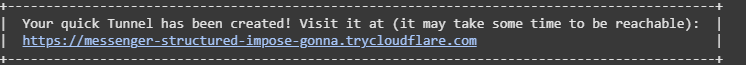

In [ ]:
!streamlit run 0_👋_Home.py &>streamlit.log &
!./cloudflared tunnel --url http://localhost:8501 --no-autoupdate --logfile cloudflared.log --loglevel info &

# mostrar URL
import time, re, pathlib, json, math, random, os, sys, html, textwrap
time.sleep(5)
log = pathlib.Path("cloudflared.log").read_text()
url = re.search(r"https://[0-9a-zA-Z\-\.]+\.trycloudflare\.com", log)
print("Abre tu dashboard en:", url.group(0) if url else "URL no encontrada todavía")


2025-07-18T04:16:41Z INF Thank you for trying Cloudflare Tunnel. Doing so, without a Cloudflare account, is a quick way to experiment and try it out. However, be aware that these account-less Tunnels have no uptime guarantee, are subject to the Cloudflare Online Services Terms of Use (https://www.cloudflare.com/website-terms/), and Cloudflare reserves the right to investigate your use of Tunnels for violations of such terms. If you intend to use Tunnels in production you should use a pre-created named tunnel by following: https://developers.cloudflare.com/cloudflare-one/connections/connect-apps
2025-07-18T04:16:41Z INF Requesting new quick Tunnel on trycloudflare.com...
2025-07-18T04:16:46Z INF +--------------------------------------------------------------------------------------------+
2025-07-18T04:16:46Z INF |  Your quick Tunnel has been created! Visit it at (it may take some time to be reachable):  |
2025-07-18T04:16:46Z INF |  https://excess-literary-string-indoor.trycloudflare.c